In [1]:
# %load_ext autoreload
# %autoreload 2

import os, sys
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

home_dir = os.environ['HOME']
sys.path.insert(0, os.path.join(home_dir, 'Dropbox/git/CMSC773'))
sys.path.insert(0, os.path.join(home_dir, 'Dropbox/git/bertviz'))
from bertviz import head_view

import dataloader
import tomotopy as tp
from itertools import chain
import tqdm
import pandas as pd
import numpy as np
import slda
import post_classifier
import bow

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('dark')

### Load

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
base_dir = 'Documents/CL2/umd_reddit_suicidewatch_dataset_v2/processed_data'
load_dir = os.path.join(home_dir, base_dir)

x_np, y_np = np.load(os.path.join(load_dir, 'train_data.npy'), allow_pickle=True)

In [4]:
x = list(map(lambda z: torch.tensor(z, dtype=torch.long, device=device), x_np))
y = torch.tensor(y_np, dtype=torch.long, device=device)

### Define model and fit

In [5]:
import torch
from transformers import BertForSequenceClassification, BertModel, BertTokenizer
torch.manual_seed(665)
np.random.seed(665)

model_version = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)
model = BertForSequenceClassification.from_pretrained(model_version, output_attentions=False).to(device)

In [6]:
large_lr_parameters_keywords = ['classifier']

param_small_lr_list = [] # should be changed into torch.nn.ParameterList()
param_large_lr_list = [] # should be changed into torch.nn.ParameterList()

for k, v in model.named_parameters():
    small_lr = True
    for keyword in large_lr_parameters_keywords:
        if keyword in k:
            param_large_lr_list.append(v)
            small_lr = False
            break
    if small_lr:
        param_small_lr_list.append(v)
        
param_small_lr_list = torch.nn.ParameterList(param_small_lr_list)
param_large_lr_list = torch.nn.ParameterList(param_large_lr_list)

In [7]:
optimizer = torch.optim.Adam([{'params': param_small_lr_list, 'lr': 1e-5},
                              {'params': param_large_lr_list, 'lr': 1e-3}])

In [8]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [9]:
def train(model, x, y, batch_size=8, update_feq=16, nb_epochs=10):
    num_samples = len(y)
    num_training_steps_per_epoch = int(np.ceil(num_samples / batch_size))
    
    loss_hist = []
    
    model.train()
    
    for i in range(nb_epochs):
        optimizer.zero_grad()
        shuffle_indices = torch.randperm(num_samples)
        
        for j in range(num_training_steps_per_epoch):
            batch_indices = slice(j*batch_size, (j+1)*batch_size)

            batch_inputs = list(map(lambda z: z[shuffle_indices][batch_indices], x))
            batch_labels = y[shuffle_indices][batch_indices]

            loss, _ = model(*batch_inputs, labels=batch_labels)
            loss /= update_feq
            loss.backward()

            loss_hist.append(loss.item())

            if (j+1) % update_feq == 0:
                
                print(i, j, loss.item())
                
                optimizer.step()
                optimizer.zero_grad()
            
    return loss_hist

In [10]:
loss_hist = train(model, x, y, batch_size=8, update_feq=8, nb_epochs=3)

0 7 0.09592167288064957
0 15 0.07090205699205399
0 23 0.0956999883055687
0 31 0.07716061174869537
0 39 0.08557704836130142
0 47 0.09047064185142517
0 55 0.07142205536365509
0 63 0.09484811127185822
0 71 0.11532615125179291
0 79 0.08429183065891266
0 87 0.10073887556791306
0 95 0.09472104161977768
0 103 0.08391354978084564
0 111 0.06636135280132294
0 119 0.07010941207408905
0 127 0.1016748771071434
0 135 0.05952117219567299
0 143 0.09837143868207932
0 151 0.10088960081338882
0 159 0.07783237099647522
0 167 0.08544918149709702
0 175 0.08588778972625732
0 183 0.09201470762491226
0 191 0.08168457448482513
0 199 0.09589952975511551
0 207 0.08201925456523895
0 215 0.08583705127239227
0 223 0.07644971460103989
0 231 0.08325960487127304
0 239 0.07396333664655685
0 247 0.08337187021970749
0 255 0.08610966801643372
0 263 0.06768263131380081
0 271 0.06459297239780426
0 279 0.08414573222398758
0 287 0.08198095113039017
0 295 0.10297584533691406
0 303 0.09527591615915298
0 311 0.08205187320709229
0

0 2487 0.06263190507888794
0 2495 0.09166116267442703
0 2503 0.06380622833967209
0 2511 0.08658567070960999
0 2519 0.059982284903526306
0 2527 0.07239870727062225
0 2535 0.06637174636125565
0 2543 0.08870895206928253
0 2551 0.08717110008001328
0 2559 0.07682763040065765
0 2567 0.06073912978172302
0 2575 0.07102333009243011
0 2583 0.08128294348716736
0 2591 0.07246159017086029
0 2599 0.0829450860619545
0 2607 0.08447183668613434
0 2615 0.06827560812234879
0 2623 0.07571382075548172
0 2631 0.1016463115811348
0 2639 0.08258863538503647
0 2647 0.05890597775578499
0 2655 0.09515705704689026
0 2663 0.08641180396080017
0 2671 0.08369554579257965
0 2679 0.1007947325706482
0 2687 0.09703665971755981
0 2695 0.11278557032346725
0 2703 0.08294305205345154
0 2711 0.082509845495224
0 2719 0.07786098122596741
0 2727 0.09905704855918884
0 2735 0.0778893455862999
0 2743 0.07484081387519836
0 2751 0.10254634916782379
0 2759 0.0839434266090393
0 2767 0.09033305943012238
0 2775 0.08205549418926239
0 2783 

1 1031 0.10566172748804092
1 1039 0.08095966279506683
1 1047 0.05751808360219002
1 1055 0.049728356301784515
1 1063 0.07653628289699554
1 1071 0.07694687694311142
1 1079 0.1023176908493042
1 1087 0.06336622685194016
1 1095 0.07018563151359558
1 1103 0.06654877960681915
1 1111 0.09949363768100739
1 1119 0.08415189385414124
1 1127 0.07062384486198425
1 1135 0.05658356100320816
1 1143 0.07168765366077423
1 1151 0.09041664749383926
1 1159 0.10407883673906326
1 1167 0.04649035260081291
1 1175 0.07755531370639801
1 1183 0.10299339890480042
1 1191 0.06612581759691238
1 1199 0.06677121669054031
1 1207 0.054181020706892014
1 1215 0.08826600760221481
1 1223 0.0857771784067154
1 1231 0.09643106907606125
1 1239 0.07705655694007874
1 1247 0.10116566717624664
1 1255 0.0823548212647438
1 1263 0.05531584843993187
1 1271 0.10444096475839615
1 1279 0.08881787955760956
1 1287 0.043430108577013016
1 1295 0.04631416127085686
1 1303 0.06749293953180313
1 1311 0.06571294367313385
1 1319 0.08543974161148071
1

1 3463 0.06220421940088272
1 3471 0.07036494463682175
1 3479 0.059267301112413406
1 3487 0.0808003842830658
1 3495 0.06975868344306946
1 3503 0.07209691405296326
1 3511 0.0755399763584137
1 3519 0.04934469982981682
1 3527 0.07139287143945694
1 3535 0.08729126304388046
1 3543 0.07633021473884583
1 3551 0.06129904463887215
1 3559 0.08078323304653168
1 3567 0.10808885842561722
1 3575 0.06291386485099792
1 3583 0.15102531015872955
1 3591 0.0806252732872963
1 3599 0.05286109074950218
1 3607 0.08106875419616699
1 3615 0.07459890842437744
1 3623 0.0509742833673954
1 3631 0.030877945944666862
1 3639 0.06166703999042511
1 3647 0.10429298132658005
1 3655 0.09001213312149048
1 3663 0.0631612241268158
1 3671 0.06562220305204391
1 3679 0.05568864569067955
1 3687 0.062757208943367
1 3695 0.06691363453865051
1 3703 0.06576618552207947
1 3711 0.09738411009311676
1 3719 0.11029408872127533
1 3727 0.05359321087598801
1 3735 0.1089562177658081
1 3743 0.0967957079410553
1 3751 0.0863988846540451
1 3759 0.

2 1991 0.0648670345544815
2 1999 0.036741387099027634
2 2007 0.049983128905296326
2 2015 0.07798725366592407
2 2023 0.09552966803312302
2 2031 0.07335767149925232
2 2039 0.05240945890545845
2 2047 0.09263798594474792
2 2055 0.09123139083385468
2 2063 0.04873272031545639
2 2071 0.040333643555641174
2 2079 0.040016308426856995
2 2087 0.04404430836439133
2 2095 0.04776954650878906
2 2103 0.07354810833930969
2 2111 0.05723443254828453
2 2119 0.05316862463951111
2 2127 0.08211259543895721
2 2135 0.0475354865193367
2 2143 0.06096424162387848
2 2151 0.0519513338804245
2 2159 0.04305332526564598
2 2167 0.0983002707362175
2 2175 0.03833666071295738
2 2183 0.061413273215293884
2 2191 0.0853639766573906
2 2199 0.07124346494674683
2 2207 0.09612537920475006
2 2215 0.04966402426362038
2 2223 0.05874679982662201
2 2231 0.07788192480802536
2 2239 0.09974339604377747
2 2247 0.08598091453313828
2 2255 0.041996411979198456
2 2263 0.024814678356051445
2 2271 0.02215125784277916
2 2279 0.05371341109275818

In [18]:
from datetime import datetime
datetime.now().strftime("[%Y_%m_%d_%H:%M]")

'[2020_05_10_04:35]'

In [20]:
base_save_dir = '/home/hadi/Documents/CL2/deep_stuff/saved_models'
mdoel_save_dir = os.path.join(base_save_dir, 'model', datetime.now().strftime("[%Y_%m_%d_%H:%M]"))
tokenizer_save_dir = os.path.join(base_save_dir, 'tokenizer', datetime.now().strftime("[%Y_%m_%d_%H:%M]"))

os.makedirs(mdoel_save_dir, exist_ok=True)
os.makedirs(tokenizer_save_dir, exist_ok=True)

In [21]:
model.save_pretrained(mdoel_save_dir)
tokenizer.save_pretrained(tokenizer_save_dir)

('/home/hadi/Dropbox/git/CMSC773/deep_stuff/saved_models/tokenizer/[2020_05_10_04:36]/vocab.txt',
 '/home/hadi/Dropbox/git/CMSC773/deep_stuff/saved_models/tokenizer/[2020_05_10_04:36]/special_tokens_map.json',
 '/home/hadi/Dropbox/git/CMSC773/deep_stuff/saved_models/tokenizer/[2020_05_10_04:36]/added_tokens.json')

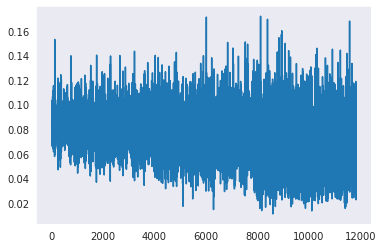

In [12]:
plt.plot(loss_hist)

In [13]:
N = 64

loss_hist_smooth = np.convolve(loss_hist, np.ones((N,))/N, mode='valid')

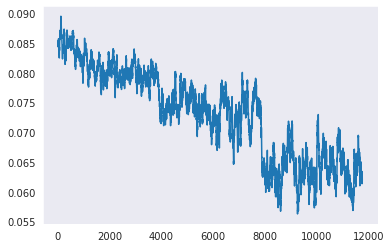

In [15]:
plt.plot(loss_hist_smooth)